# Cross Stitch Patterns from Images

This code will create a counted cross-stitch pattern from an image by pixellating it, determining color maps and replacing each pixel by an x in the designated color.  One can choose how many different colors to allow for a given image so that it is possible to minimize the complexity.  A color count of stitches will also be reported so the relative amounts of different color threads can be determined.

In [4]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## Load image file

In [100]:
import scipy.ndimage as ndi
from scipy.misc import imresize
import requests
from StringIO import StringIO


In [101]:
response = requests.get("http://upload.wikimedia.org/wikipedia/commons/1/1c/CMS_Higgs-event.jpg")
pic = ndi.imread(StringIO(response.content))
print type(pic)

<type 'numpy.ndarray'>


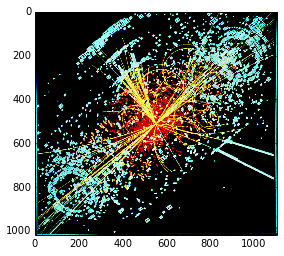

In [102]:
plt.imshow(pic);

In [103]:
print pic.shape
print pic[100,100]

(1018, 1104, 3)
[0 0 0]


Cross-stitching is done with a material called "Aida Cloth".  The size of the weave is measured by how many stitches can be made in one inch. This is called the fabric's count. The most common counts in Aida Cloth are 11, 14, 18 and 28. The higher the number, the smaller the stitches will be, because there are more stitches in each inch. 

For a 20 inch by 20 inch picture, using 14 count Aida Cloth, you have 280 stitches by 280 stitches.  

If you want to reproduce a picture pixel for pixel, divide the number of pixels in a given dimension by the fabric count for the Aida Cloth you intend to use.  That will show you how large the resulting pattern will be.  e.g. for the Higgs event shown above, with 28 count Aida cloth, the image will be 39 x 36 inches - 3 feet by 3 feet.  

# Image adjustment

In [104]:
#resize image
def resize(image,scale=25):
    """scale = % to resize.  This seems to also convert the 0-1 colors to integer RGB"""
    return imresize(image,scale,mode="RGB")

In [105]:
import scipy as sp
from scipy.cluster.vq import kmeans,vq
from sklearn.utils import shuffle

In [106]:
#Kmeans algorithm to reduce number of colors
def reduce_colors(image, k):
    '''Apply kmeans algorithm.
   Input:  image, number of clusters to use
   Output: colors, counts per color, new image'''
    rows, cols, rgb = image.shape
    # reshape the image in a single row array of RGB pixels
    image_row = np.reshape(image,(rows * cols, 3))
    #HERE ADD CODE TO GET A GOOD GUESS OF COLORS AND PASS THAT AS
    #SECOND ARGUMENT TO kmeans
    #image_array_sample = shuffle(image_row, random_state=0)[:1000]
    #kguess = kmeans(image_array_sample, k)
    #colors,_ = kmeans(image_row, kguess)
    # perform the clustering
    colors,_ = kmeans(image_row, k)
    # vector quantization, assign to each pixel the index of the nearest centroid (i=1..k)
    qnt,_ = vq(image_row,colors)
    # reshape the qnt vector to the original image shape
    image_centers_id = np.reshape(qnt,(rows, cols))
    # assign the color value to each pixel
    newimage = colors[image_centers_id]
    #count number of pixels of each cluster color
    counts,bins = sp.histogram(qnt, len(colors))
    return colors, counts, newimage

# Color/Floss counting

In [107]:
#count colors
def color_count(image):
    """Considering a (w,h,3) image of (dtype=ubyte),
    compute the number of unique colors\n"""
    F = image[...,0]*256*256 + image[...,1]*256 + image[...,2]
    unique, counts = np.unique(F, return_counts=True)
    return unique, counts

In [108]:
#Found an online RGB<-->DMC floss color conversion table to reference.
def load_floss_colors(example=True):
    values = np.loadtxt('DMCtoRGB_UK.txt', delimiter=' , ',dtype=int, usecols=[0,2,3,4])
    labels = np.loadtxt('DMCtoRGB_UK.txt', delimiter=' , ',dtype=str, usecols=[1,5])
    if example:
        print "Example: ",values[27],labels[27]
    return values,labels

In [109]:
#Use distance in RGB space to determine closest color match
def match_color(rgb):
    """for a given r,g,b tuple, determine the closest DMC thread color"""
    values,labels = load_floss_colors(False)
    #Compute distance to nearest color in RGB space
    rdiff2 = (rgb[0]-values[:,1])**2
    gdiff2 = (rgb[1]-values[:,2])**2
    bdiff2 = (rgb[2]-values[:,3])**2
    cdiff = np.sqrt(rdiff2+gdiff2+bdiff2)
    #print "Input rgb: ",rgb,"\tClosest match:",values[cdiff.argmin()],labels[cdiff.argmin()]
    return values[cdiff.argmin()],labels[cdiff.argmin()]

In [110]:
#Print and return the matched floss counts
def floss_color_counts(colors,counts):
    '''print the matched floss colors and counts'''
    mycounts = counts.copy() #copy so we don't mess up the original arrays
    inds = mycounts.argsort()
    sortedcolors = colors[inds].copy() #copy so we don't mess up the original arrays
    mycounts.sort()
    
    #floss length per stitch for 14-count aida cloth
    boxsize = 25.4/14 #mm
    #diagonal of box
    boxdiag = np.sqrt(2*boxsize**2)
    threadperstitch = 2*boxdiag + 2*boxsize
    threadperstitch *= 1.2 #increase by 20% to account for extras and gaps between stitches
    
    threadpercolor = mycounts*threadperstitch/1000. #number of meters of floss needed in each color
    #floss comes in skeins of 8.7 yards of 6-stranded thread.  Typical 14-count patterns take 2 strands
    flosslength = 3*8.7*0.9144 #convert yards of 6-stranded thread to meters of 2-stranded thread
    skeinspercolor = threadpercolor/flosslength # need to round up
    #print "Box size (mm): %.2f, Box diag (mm): %.2f, threadperstitch (mm): %.2f, flosslength (m): %.2f"%(boxsize,boxdiag,threadperstitch,flosslength)
    #print "THREADPERCOLOR (m):",threadpercolor[-1:0:-1]
    #print "SKEINSPERCOLOR:",skeinspercolor[-1:0:-1]
    
    #Create a list of skein color count, code, and name
    summary = []
    print "Counts\tRGBColor\tMatchedFloss\t\t#Skeins\tFlossName"
    print "====================================================================================="    
    for i in range(len(counts)-1,-1,-1):
        matches = match_color(sortedcolors[i])
        print mycounts[i],"\t",sortedcolors[i],"\t",matches[0],"\t %.2f"%skeinspercolor[i],"\t",matches[1]
        summary.append((float("%.2f"%skeinspercolor[i]),matches[0][0],matches[1][0]))

    return summary

# Utilities

In [111]:
#Print some useful pattern info
def aida_size(pic,aida=14):
    """Given an Aida cloth count and an image of a given number of pixels,
    report the size of the resulting pattern in inches"""
    x,y,col = pic.shape
    print "Pixel dimensions: (%d x %d)"%(x,y)
    print "Aida Cloth count: %d"%aida
    print "Pattern dimensions: (%.2f in x %.2f in)"%(x/float(aida),y/float(aida))
    print "Pattern colors: %d"%(color_count(pic)[0]).size

In [112]:
#Plot the image before and after manipulation
def plot_before_after(before,after,text="Transformed"):
    cb = color_count(before)[0].size
    ca = color_count(after)[0].size
    # Two subplots, the axes array is 1-d
    f, axarr = plt.subplots(1,2,figsize=(12, 6))
    axarr[0].imshow(before)
    axarr[0].set_title('Original image (%d colors)'%cb)
    axarr[1].set_title('%s image (%d colors)'%(text,ca))
    axarr[1].imshow(after);

#Applied to Data 

## Resize the image

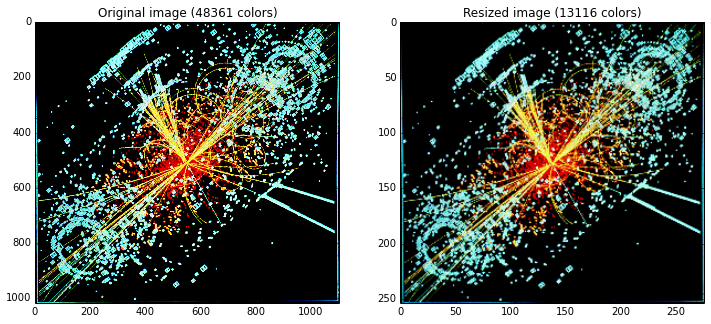

In [113]:
before = pic
smaller = resize(pic)
plot_before_after(before,smaller,"Resized")

---

#Apply color algorithm

In [169]:
#Takes a while.  We might try seeding the kmeans with decent guesses, 
#similar to what is done in scikit-learn
colors, counts, after = reduce_colors(smaller, 18)

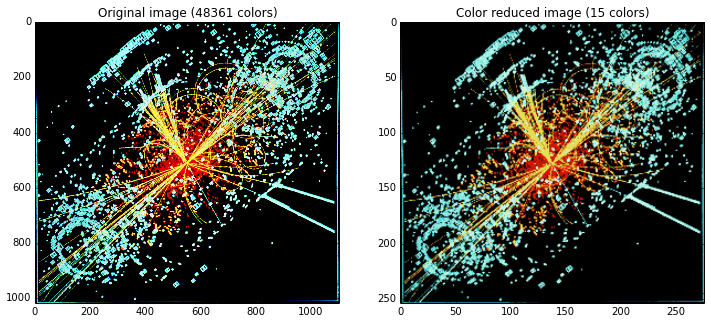

In [170]:
plot_before_after(before,after,"Color reduced")

# Show the results of the color match

In [171]:
#Counts of each color in RGB
summary = floss_color_counts(colors,counts)
#print summary

Counts	RGBColor	MatchedFloss		#Skeins	FlossName
46070 	[0 0 0] 	[310   0   0   0] 	 20.29 	['Black' '0x000000']
3862 	[144 234 224] 	[996 170 222 225] 	 1.70 	['Electric Blue - MED' '0xAADEE1']
3761 	[203 244 228] 	[827 213 231 232] 	 1.66 	['Blue - VY LT' '0xD5E7E8']
2494 	[229 222  83] 	[3821  243  195   91] 	 1.10 	['Straw' '0xF3C35B']
1634 	[ 76 222 220] 	[3846   82  173  234] 	 0.72 	['Bright Turquoise - LT' '0x52ADEA']
1570 	[ 5 19 36] 	[939   0   0  49] 	 0.69 	['Navy Blue - VY DK' '0x000031']
1413 	[41 14  5] 	[310   0   0   0] 	 0.62 	['Black' '0x000000']
1404 	[ 73 175 157] 	[3851   90  165  140] 	 0.62 	['Bright Green - LT' '0x5AA58C']
1391 	[210 141  34] 	[3852  220  163   59] 	 0.61 	['Straw - VY DK' '0xDCA33B']
1298 	[19 68 66] 	[3842   12   65   88] 	 0.57 	['Wedgwood - DK' '0x0C4158']
1254 	[219  19   5] 	[900 206  43   0] 	 0.55 	['Burnt Orange - DK' '0xCE2B00']
1187 	[ 25 114 130] 	[3809   31  107  123] 	 0.52 	['Turquoise - VY DK' '0x1F6B7B']
974 	[103 122  39] 	[905

In [172]:
aida_size(after,aida=14)

Pixel dimensions: (254 x 276)
Aida Cloth count: 14
Pattern dimensions: (18.14 in x 19.71 in)
Pattern colors: 15


# Create pattern

Now that I have reduced the number of pixels and the number of colors, I need to represent each color by an ascii character, then create a new 2d array with the character in each array element representing the color of that array element.

##Pattern
1. Choose a set of ASCII characters that look unique from each other.  
2. Assign each one to represent a color in the reduced image.
3. Create a 2-D array whose value at each x-y location is the ASCII code for each character
4. Use a standard 5 mm x 5 mm square for each pixel.  Given the pixel size of the image, determine how many 8.5"x11" pieces of paper would be needed to show the whole image with squares of this size.  
5. Create a set of block grid outlines for the reduced image using the squares and number of sheets determined in step 4.
6. Outline every 10x10 region in a heavier color to ease the counting.
7. Inside each grid block, print the ASCII character associated with the code in the 2-D array.

In [157]:
def locate_color(image,color):
    indices = np.where(np.all(image == color, axis=-1))
    #print zip(indices[0], indices[1])
    return indices[0], indices[1]

In [161]:
eb = (127, 232, 223) #Electric blue
c = (215, 19, 5) #Burnt orange
pg = (104, 124,  44) #parrot green
x,y = locate_color(after,pg)
#print x,y

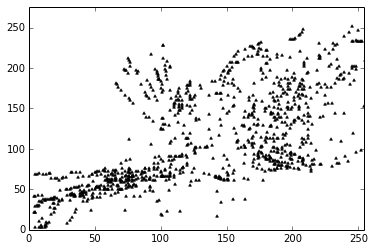

In [164]:
#plot symbols corresponding to different values
symbol = [u'\u002B', u'\u002F', u'\u003D', u'\u007C',u'\u005A', u'\u004E', u'\u004F', u'\u01C2', u'\u2022', u'\u25B2']

#Invert the y values to plot the image with 0,0 in the lower left corner
plt.plot(y[::-1],x, 'k', marker="$%s$" % symbol[9], markersize=3,lw = 0)
plt.xlim(0,254)
plt.ylim(0,276);


(0.0, 27.600000000000001)
(0.0, 25.399999999999999)


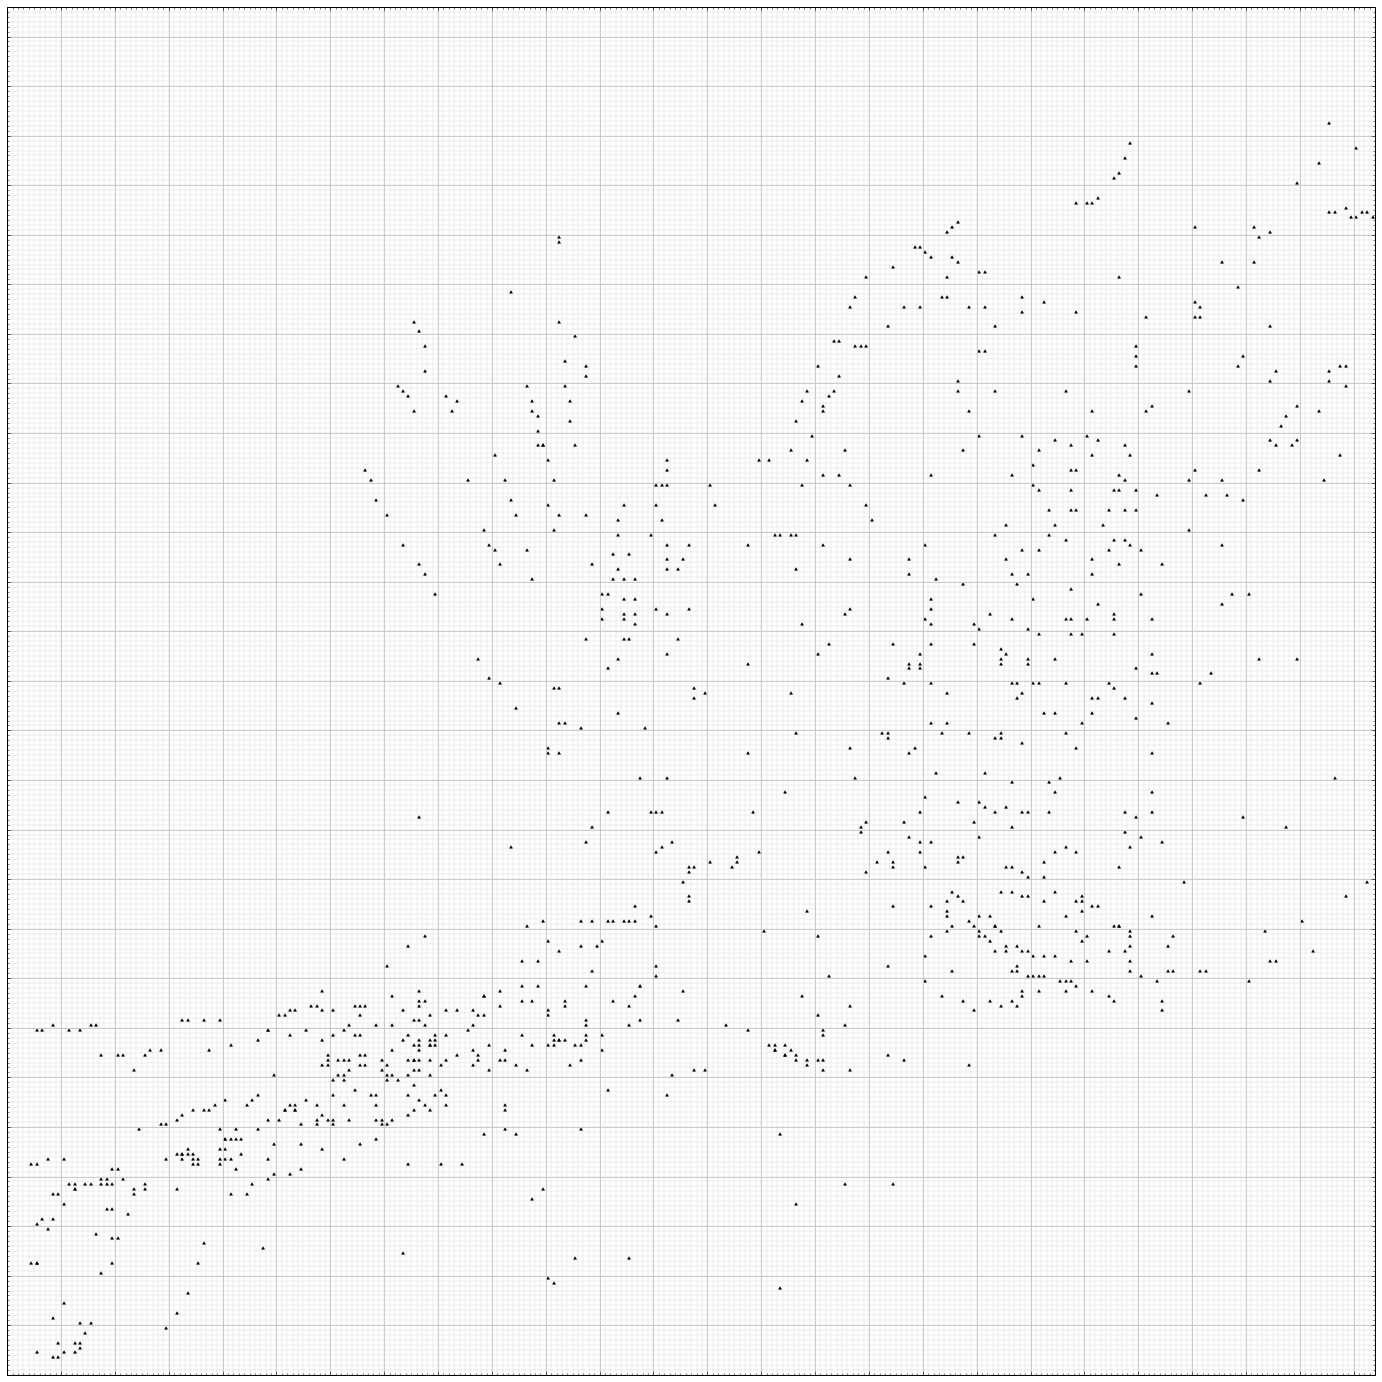

In [165]:
#From https://scipy-lectures.github.io/intro/matplotlib/matplotlib.html#axes
plt.figure(figsize=(20,20))
ax = plt.axes([0.025, 0.025, 0.95, 0.95])

ax.set_xlim(0,25.4)
ax.set_ylim(0,27.6)
ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1.0))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75')
ax.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75')
ax.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75')
ax.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75')
ax.set_xticklabels([])
ax.set_yticklabels([])

print ax.get_ylim()
print ax.get_xlim()
#Flip the y coordinates to invert the image properly
plt.plot((y[::-1]/10.)+0.05,(x/10.)+0.05,  'k', marker="$%s$" % symbol[9], lw = 0,markersize=3)